# Load MNIST Dataset

In [5]:
from sklearn.datasets import fetch_openml
x,y = fetch_openml("mnist_784", return_X_y=True)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

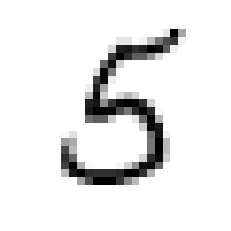

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def display(x, idx):
    image = x[idx].reshape(28,28)
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()
    
display(X_train, 0)

# Visualization

<Figure size 576x576 with 0 Axes>

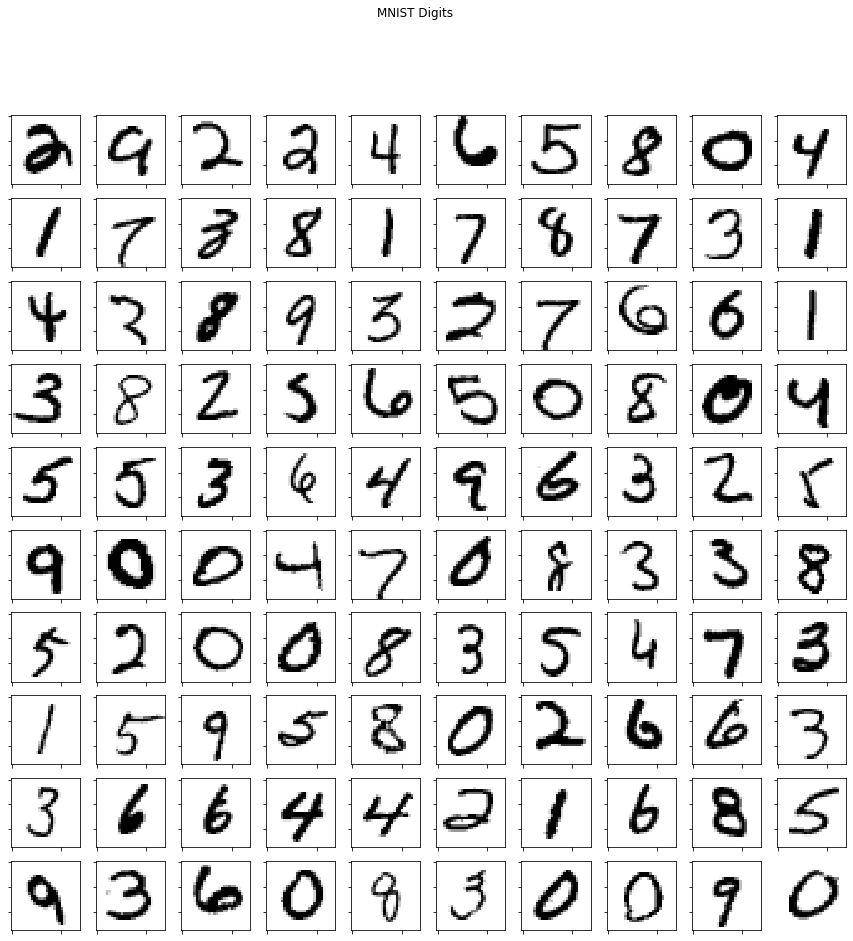

In [91]:
index = np.random.randint(0, len(X_train), 100)
samples = X_train[index]
plt.figure(figsize=(8,8))
fig, axs = plt.subplots(10,10, figsize=(15,15))
fig.suptitle('MNIST Digits')
for i, ax in enumerate(axs.flat):
    ax.imshow(samples[i].reshape(28,28), cmap=matplotlib.cm.binary, interpolation="nearest")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.axis("off")
plt.show()

# Train SGDClassifier

In [22]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

sgd_clf = SGDClassifier(random_state=42)
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

sgd_clf.fit(X_train, y_train_5)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

print("Precision={}, Recall={}, F1 Score={}".format(precision, recall, f1))
confusion_matrix(y_train_5, y_train_pred)

Precision=0.8515332009706597, Recall=0.7658730158730159, F1 Score=0.8064347644416588


array([[50287,   673],
       [ 1180,  3860]])

# Metrics

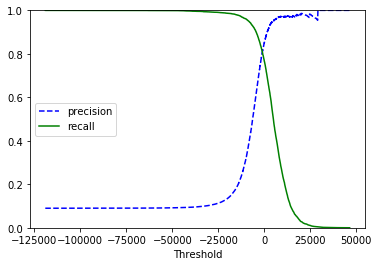

In [31]:
from sklearn.metrics import precision_recall_curve

y_score = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

def draw_precision_recall(y_train, y_score):
    precision, recall, threshold = precision_recall_curve(y_train, y_score)
    plt.plot(threshold, precision[:-1], "b--", label="precision")
    plt.plot(threshold, recall[:-1], "g-", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
draw_precision_recall(y_train_5, y_score)

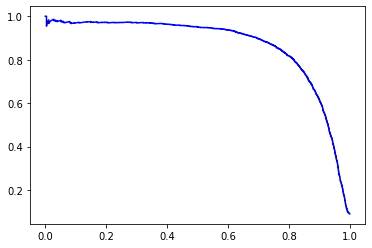

In [28]:
plt.plot(recall[:-1], precision[:-1], "b-")

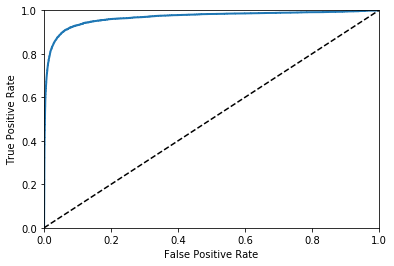

In [32]:
from sklearn.metrics import roc_curve

def draw_roc_curve(y_train, y_score):
    fpr, tpr, threshold = roc_curve(y_train, y_score)
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
draw_roc_curve(y_train_5, y_score)

# Train MLP

In [33]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,50), early_stopping=True)
mlp.fit(X_train, y_train_5)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [36]:
mlp_score = cross_val_predict(mlp, X_train, y_train_5, cv=3)
precision = precision_score(y_train_5, mlp_score)
recall = recall_score(y_train_5, mlp_score)
f1 = f1_score(y_train_5, mlp_score)
print("Precision={}, Recall={}, F1 Score={}".format(precision, recall, f1))

Precision=0.9615542763157895, Recall=0.9279761904761905, F1 Score=0.9444668820678515


In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


def get_best_mlp(train, label):
    model = Pipeline([
        ('standard_scale', StandardScaler()),
        ('mlp', MLPClassifier())
    ])

    params = [{'mlp__hidden_layer_sizes': [(10,10), (20,20), (40,40), (50,50)]}]
    grid_search = GridSearchCV(model, param_grid=params, cv=5)
    grid_search.fit(train, label)
    print("Best Score={}".format(grid_search.best_score_))
    return grid_search.best_estimator_

model = get_best_mlp(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

Best Score=0.9675535714285715


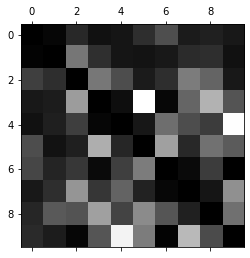

In [71]:
import numpy as np

def display_conf_matrix(model, train, label):
    y_train_pred = cross_val_predict(model, train, label, cv=5)
    conf_matrix = confusion_matrix(label, y_train_pred)
    normalized_conf_matrix = conf_matrix/conf_matrix.sum(axis=1)
    np.fill_diagonal(normalized_conf_matrix, 0)
    plt.matshow(normalized_conf_matrix, cmap=plt.cm.gray)

display_conf_matrix(model, X_train, y_train)

# Add Noise to Data

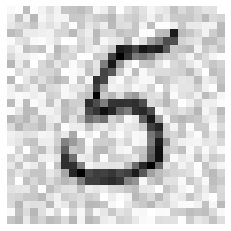

In [53]:
noise = np.random.randint(0, 100, (len(X_train), 784))
noisy_train = X_train + noise
display(noisy_train, 0)

In [67]:
concat_x = np.concatenate([X_train, noisy_train], axis=0)
concat_y = np.concatenate([y_train, y_train], axis=0)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

Best Score=0.9757232142857143


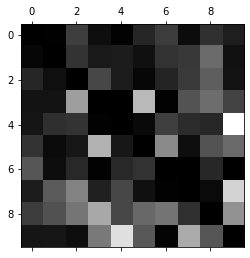

In [73]:
model = get_best_mlp(concat_x, concat_y)
display_conf_matrix(model, concat_x, concat_y)

In [85]:
concat_pred = cross_val_predict(model, concat_x, concat_y, cv=5)

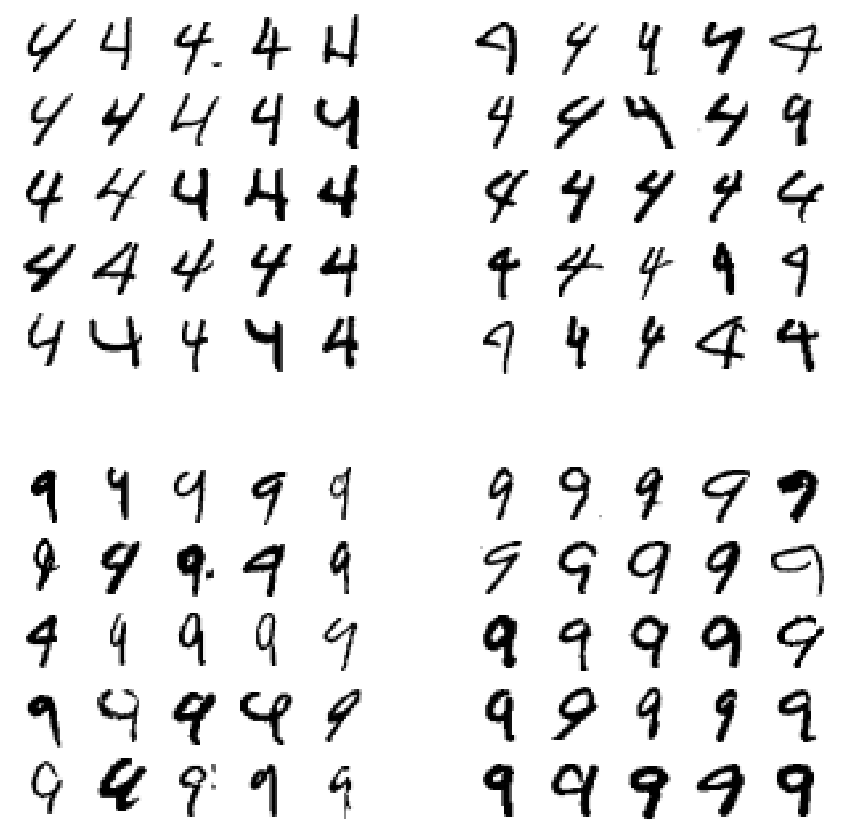

In [92]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = '4', '9'
X_aa = concat_x[(concat_y== cl_a) & (concat_pred == cl_a)]
X_ab = concat_x[(concat_y== cl_a) & (concat_pred == cl_b)]
X_ba = concat_x[(concat_y== cl_b) & (concat_pred == cl_a)]
X_bb = concat_x[(concat_y== cl_b) & (concat_pred == cl_b)]

plt.figure(figsize=(15,15))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Histogram of Oriented Gradients

In an image, edges and corners have a lot of information about what the image is. We know that gradient of an image is largest along its edges and corners. Therefore, the HOG feature descriptor (distribution of gradient directions) could be a very good indicator. 

HOG descriptors are not rotation-invariant. This is good in digit classification since a 2 could be rotated (180 degree) to look like a 5.

\begin{align}
g_x = \frac{\partial I}{\partial x} = \begin{bmatrix}
-1 \\
0 \\
+1 \\
\end{bmatrix}^T * I \\
g_y = \frac{\partial I}{\partial y} = \begin{bmatrix}
-1 \\
0 \\
+1 \\
\end{bmatrix} * I \\
\theta = \tan^{-1} [\frac{g_y}{g_x}] \\
magnitude = \sqrt{g_{y}^2 + g_{x}^2}
\end{align}

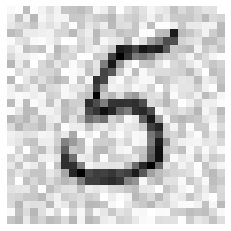

(1568,)


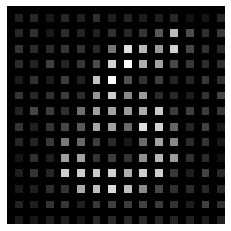

In [104]:
from skimage.feature import hog

def display_hog(x, idx):
    fd, hog_image = hog(x[idx].reshape(28,28), orientations=8, pixels_per_cell=(2, 2),
                        cells_per_block=(1, 1), visualize=True, multichannel=False)
    plt.axis('off')
    plt.imshow(hog_image, cmap=plt.cm.gray)
    plt.show()
    
display(noisy_train, 0)
display_hog(noisy_train, 0)

In [121]:
def histogram(x):
    return hog(x.reshape(28,28), orientations=8, pixels_per_cell=(2, 2), cells_per_block=(1, 1), visualize=False, multichannel=False)

hogs = np.array(list(map(histogram, X_train)))

Best Score=0.978


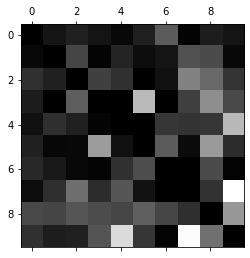

In [126]:
def get_best_mlp_with_hogs(train, label, params = [{'mlp__hidden_layer_sizes': [(50,50)]}]):
    model = Pipeline([
        ('mlp', MLPClassifier())
    ])
    grid_search = GridSearchCV(model, param_grid=params, cv=5)
    grid_search.fit(train, label)
    print("Best Score={}".format(grid_search.best_score_))
    return grid_search.best_estimator_

hogs_model = get_best_mlp_with_hogs(hogs, y_train)
display_conf_matrix(hogs_model, hogs, y_train)